In [18]:
import re, sys
import functools
import numpy as np
#from graphviz import Digraph, Source
from pathlib import Path
from pynini import Weight

from wynini import config as wyconfig
from wynini.wywrapfst import *

In [20]:
help(wyconfig)
wyconfig.init({'sigma': ['a', 'b', 'c']})

Help on module wynini.config in wynini:

NAME
    wynini.config

FUNCTIONS
    init(param={})
        Set globals with dictionary or module.

    make_symtable(sigma)

DATA
    bos = '⋊'
    eos = '⋉'
    epsilon = 'ϵ'
    sigma = ['a', 'b', 'c']
    special_syms = []
    syms = ['ϵ', '⋊', '⋉', 'a', 'b', 'c']
    symtable = <SymbolTable '<unspecified>'>
    unk = '⊥'
    verbosity = 0
    λ = ''

FILE
    /home/colin/Code/Python/wynini/wynini/config.py




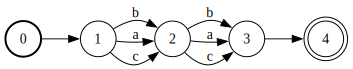

In [21]:
M = braid(2, arc_type='log')
one = Weight('log', 0.0)
M.assign_weights(lambda M, q, t: one)

M.viz()

In [4]:
beta = shortestdistance(M, reverse=True)
beta = np.array([float(w) for w in beta])
print(np.exp(-beta))

[9.00000038 9.00000038 3.00000006 1.         1.        ]


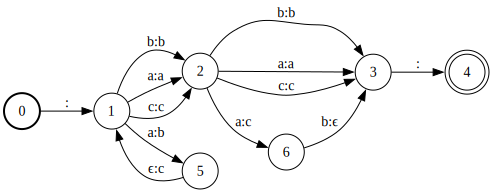

In [5]:
# Add paths.
M.add_path(src=1, ilabel='a', olabel='b c', weight=None, dest=1)
M.add_path(src=2, ilabel='a b', olabel='c', weight=None, dest=3)
M.viz()

0	1	⋊	⋊
1	2	a	a
2

0	1	b	b
1	2	⋉	⋉
2

(0, 1)	(1, 1)	⋊	⋊
(1, 1)	(2, 1)	a	a
(2, 1)	(0, 2)	ϵ	ϵ
(0, 2)	(1, 2)	b	b
(1, 2)	(2, 2)	⋉	⋉
(2, 2)

[('⋊ a b ⋉', <tropical Weight 0 at 0x7fd28023eb30>)]

0	(0, 1)	ϵ	ϵ
0	(0, 2)	ϵ	ϵ
(0, 1)	(1, 1)	⋊	⋊
(1, 1)	(2, 1)	a	a
(2, 1)
(0, 2)	(1, 2)	b	b
(1, 2)	(2, 2)	⋉	⋉
(2, 2)

[('⋊ a', <tropical Weight 0 at 0x7fd28023c290>), ('b ⋉', <tropical Weight 0 at 0x7fd28023d810>)]


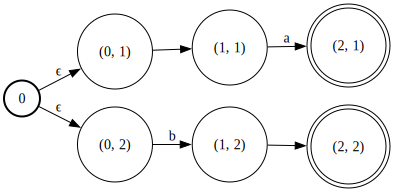

In [6]:
# Concatenation, union, optionality, star.
wfst1 = accep(f'{config.bos} a', add_delim=False)
# wfst1 = Wfst()
# q0 = wfst1.add_state(initial=True)
# q1 = wfst1.add_state(final=True)
# wfst1.add_arc(q0, 'a', 'a', None, q1)
print(wfst1.print())

wfst2 = accep(f'b {config.eos}', add_delim=False)
# wfst2 = Wfst()
# q0 = wfst2.add_state(initial=True)
# q1 = wfst2.add_state(final=True)
# wfst2.add_arc(q0, 'b', 'b', None, q1)
print(wfst2.print())

# Concatenation.
wfst_ = concat(wfst1, wfst2)
print(wfst_.print())
print(list(wfst_.accepted_strings(delete_epsilon=True)))
print()

# # Union.
wfst_ = union(wfst1, wfst2)
print(wfst_.print())
print(list(wfst_.accepted_strings(delete_epsilon=True)))
wfst_.viz()

# # Optionality.
# wfst = ques(wfst1)
# print(wfst.print())

# # Star.
# wfst = star(wfst1)
# print(wfst.print())

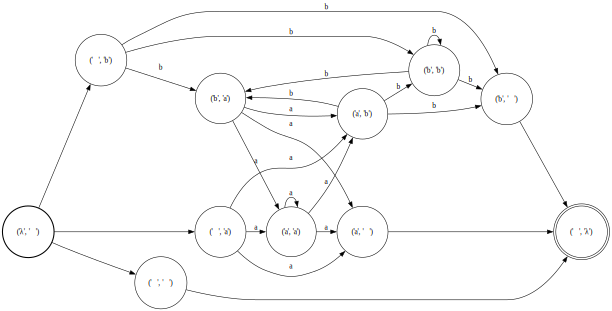

In [7]:
# N-gram machines.
config.init({'sigma': ['a', 'b']})
M = ngram(context='both', length=1)

# Flatten labels.
def relabel_func(wfst, q):
    label = wfst.state_label(q)
    label_ = tuple(' '.join(x) for x in label)
    return label_
M = M.relabel_states(relabel_func)

M.viz()

0	1	⋊	⋊
1	2	b_0	b_0
2	3	a_1	a_1
3	4	b_2	b_2
4	5	⋉	⋉
5

0	1	⋊	⋊
1	2	b	b
2	3	a	a
3	4	b	b
4	5	⋉	⋉
5

(0, 0)	(1, 1)	⋊	⋊
(1, 1)	(2, 2)	b_0	b
(2, 2)	(3, 3)	a_1	a
(3, 3)	(4, 4)	b_2	b
(4, 4)	(5, 5)	⋉	⋉
(5, 5)



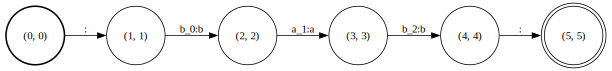

In [8]:
# Matching functions in compose().
input_ = 'bab'
input_ = [f'{x}_{i}' for i, x in enumerate(input_)]
isymbols = set(input_)
input_ = accep(' '.join(input_), isymbols)
print(input_.print())

output_ = 'bab'
output_ = [x for x in output_]
osymbols = set(output_)
output_ = accep(' '.join(output_), osymbols)
print(output_.print())

M = compose(input_, output_, matchfunc1 = lambda x : re.sub('_[0-9]+$', '', x))
print(M.print())
M.viz()

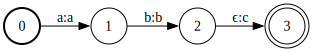

In [9]:
# String map.
M = trans('a b', 'a b c')
M.viz()

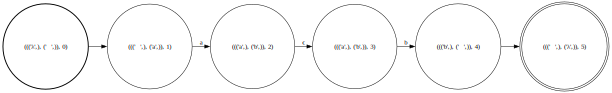

In [10]:
# Treatment of output epsilons in composition.
config.init({'sigma': ['a', 'b']})
M = ngram(context='both', length=1)
M.viz()

input_ = f'a {config.epsilon} b'
I = accep(input_)
I.viz()

A = compose(M, I)
A.viz()

5	4	ϵ	ϵ
0
1	0	⋉	⋉
2	1	a	a
3	2	a	a
4	3	⋊	⋊



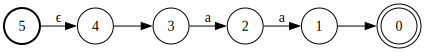

In [11]:
# Shortest (Viterbi) path.
A1 = accep('a a', arc_type='standard', weight=Weight('tropical', 0.0))
A2 = accep('a b', arc_type='standard', weight=Weight('tropical', 1.0))
A = union(A1, A2)

A_best = shortestpath(A)
print(A_best.print())

A.viz()
A_best.viz()

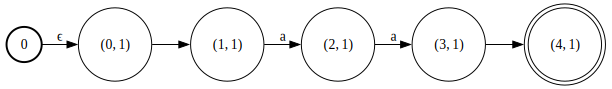

In [13]:
A_best = shortestpath_(A).connect()
A_best.viz()